# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching

In [2]:
import matplotlib.pyplot as plt
from statistics import NormalDist
import math

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [3]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=imprint', 'case/server=malicious-model'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cpu:0') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=torch.float)
setup

Investigating use case single_imagenet with server type malicious_model.
Attack settings are:
type: analytic
attack_type: imprint-readout



{'device': device(type='cpu', index=0), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [4]:
target_batch_size = 2**14
estimate_prob = breaching.analysis.imprint_guarantee.one_shot_guarantee(2**14, 2**14)

print(f'{estimate_prob:.2%} of 1-shot attacks will perfectly uncover a single data point '
      f'out of the given batch of {target_batch_size} data points.')

25.00% of 1-shot attacks will perfectly uncover a single data point out of the given batch of 16384 data points.


In [5]:
cfg.case.user.data_idx = 200
cfg.case.user.data_with_labels = 'random'

cfg.case.user.num_data_points = target_batch_size

cfg.case.model = 'none'

cfg.case.server.model_modification.type = 'OneShotBlock' 
cfg.case.server.model_modification.num_bins = target_batch_size
cfg.case.server.model_modification.position = None # '4.0.conv'
cfg.case.server.model_modification.connection = 'add'


cfg.case.server.model_modification.linfunc = 'fourier'
cfg.case.server.model_modification.mode = 32

### Instantiate all parties

In [6]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

Model architecture <class 'torch.nn.modules.container.Sequential'> loaded with 301,058 parameters and 0 buffers.
Overall this is a data ratio of       0:1 for target shape [16384, 3, 224, 224] given that num_queries=1.


In [7]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep with settings:
            number of data points: 16384
            number of user queries 1

            Threat model:
            User provides labels: True
            User provides number of data points: True

            Model:
            model specification: Sequential
            loss function: CrossEntropyLoss()

            Data:
            Dataset: ImageNet
            data_idx: 200
        


In [8]:
user.model[1].bins

[0.0, 8.632201453515401e-05]

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [9]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

# Reconstruct user data

In [10]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, 
                                                      server.secrets, dryrun=cfg.dryrun)

In [11]:
reconstructed_user_data.keys()

dict_keys(['data', 'labels'])

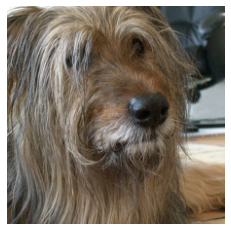

In [12]:
found_data = dict(data = reconstructed_user_data['data'][1:2], labels=None)
user.plot(found_data, scale=False)

### Identify id of user data with this value:

14244


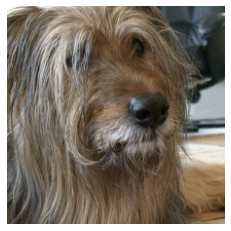

In [13]:
block_lin = user.model[1].linear0.weight[0]
matches = dict()
for idx, data in enumerate(true_user_data['data']):
    matches[idx] = torch.dist(found_data['data'], data)
idx = min(matches, key=matches.get)
print(idx)
matching_user_data = dict(data = true_user_data['data'][idx][None,...], labels=true_user_data['labels'][idx:idx+1])
user.plot(matching_user_data, scale=False)

In [14]:
#How good is the reconstruction?
metrics = breaching.analysis.report(found_data, matching_user_data, 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=False, compute_full_iip=False, skip_rpsnr=True)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/jonas/miniconda3/envs/dl/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
METRICS: | MSE: 0.0000 | PSNR: 106.48 | FMSE: 6.3622e-10 | LPIPS: 0.00| R-PSNR:  nan | IIP-pixel: 100.00%
